# Note:

This notebook is a copy from existing Kaggle notebook from a course project. The data connected is https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

In [1]:
# Import library
import os
import shutil
import random
import time

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
import torchvision.models as models

# Set SEED
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 0. Import dataset
Transform data to use pytorch DataLoader 

In [2]:
train_ratio = 0.8
test_ratio = 0.2

train_path = r'./train/'
test_path = r'./test/'
data_location = r'/kaggle/input/satellite-image-classification/data'

In [3]:
class_name = os.listdir(data_location)
print(f"Class: {class_name}\n")

try:
    os.mkdir(train_path)
    os.mkdir(test_path)
except FileExistsError:
    pass

for x in class_name:
    try:
        os.mkdir(os.path.join(train_path,x))
        os.mkdir(os.path.join(test_path,x))
    except FileExistsError:
        pass

for dirname, _, filenames in os.walk('./'):
        print(dirname)

Class: ['cloudy', 'desert', 'green_area', 'water']



./

./test

./test/green_area

./test/desert

./test/water

./test/cloudy

./.virtual_documents

./train

./train/green_area

./train/desert

./train/water

./train/cloudy


In [4]:
#     Remove any image before
for x in class_name:
    cur_dir = os.path.join(train_path, x)
    [os.remove(os.path.join(cur_dir,x_)) for x_ in os.listdir(cur_dir)]
    cur_dir = os.path.join(test_path, x)
    [os.remove(os.path.join(cur_dir,x_)) for x_ in os.listdir(cur_dir)]
    

for x in class_name:
    cur_dir = os.path.join(data_location,x)
    print(f"{len(os.listdir(cur_dir))} image - {cur_dir}")
    
    train, test = train_test_split(os.listdir(cur_dir),train_size = 0.8,shuffle = True)
    
    for train_ in train:
        shutil.copyfile(os.path.join(cur_dir, train_),os.path.join(train_path, x, train_))
    
    for test_ in test:
        shutil.copyfile(os.path.join(cur_dir, test_),os.path.join(test_path, x, test_))
        
    print(f"train : {len(os.listdir(os.path.join(train_path,x)))} images")
    print(f"test  : {len(os.listdir(os.path.join(test_path,x)))} images")
    print()

1500 image - /kaggle/input/satellite-image-classification/data/cloudy

train : 1200 images

test  : 300 images



1131 image - /kaggle/input/satellite-image-classification/data/desert

train : 904 images

test  : 227 images



1500 image - /kaggle/input/satellite-image-classification/data/green_area

train : 1200 images

test  : 300 images



1500 image - /kaggle/input/satellite-image-classification/data/water

train : 1200 images

test  : 300 images




In [5]:
# Check
for dirname, _, filenames in os.walk('./'):
    for x in filenames[0:3]:
        print(os.path.join(dirname,x))
    if len(filenames) > 3:
        print(dirname, "...")
    print()

./__notebook_source__.ipynb

./stats.csv





./test/green_area/Forest_2242.jpg

./test/green_area/Forest_319.jpg

./test/green_area/Forest_2995.jpg

./test/green_area ...



./test/desert/desert(7).jpg

./test/desert/desert(346).jpg

./test/desert/desert(839).jpg

./test/desert ...



./test/water/SeaLake_853.jpg

./test/water/SeaLake_462.jpg

./test/water/SeaLake_2863.jpg

./test/water ...



./test/cloudy/train_13047.jpg

./test/cloudy/train_21151.jpg

./test/cloudy/train_21872.jpg

./test/cloudy ...







./train/green_area/Forest_194.jpg

./train/green_area/Forest_495.jpg

./train/green_area/Forest_715.jpg

./train/green_area ...



./train/desert/desert(238).jpg

./train/desert/desert(221).jpg

./train/desert/desert(875).jpg

./train/desert ...



./train/water/SeaLake_2424.jpg

./train/water/SeaLake_1676.jpg

./train/water/SeaLake_2974.jpg

./train/water ...



./train/cloudy/train_16787.jpg

./train/cloudy/train_6105.jpg

./train/cloudy/train_5216.jpg

./train/cloudy ...




# 1. Load Data using DataLoader

In [6]:
# calculated seperately)
# mean=(0.4914, 0.4822, 0.4465),std=(0.2023, 0.1994, 0.2010)
# Set batch_size to be 64

batch_size = 64
target_image_dim = 224 
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(target_image_dim),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                             std=(0.2023, 0.1994, 0.2010))
    ])


print(train_path)

train_dataset = datasets.ImageFolder(root=train_path,
                                           transform=data_transform)

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=4)

print(train_dataset_loader.dataset.classes)

print(test_path)

test_dataset = datasets.ImageFolder(root=test_path,
                                           transform=data_transform)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=4)

print(test_dataset_loader.dataset.classes)

./train/

['cloudy', 'desert', 'green_area', 'water']

./test/

['cloudy', 'desert', 'green_area', 'water']


In [7]:
count = 0
for x in list(enumerate(train_dataset_loader)):
    count += x[1][0].shape[0]
print(f"{count:5d} train images, each with dimension {list(x[1][0].shape)[1:]}")

count = 0
for x in list(enumerate(test_dataset_loader)):
    count += x[1][0].shape[0]
print(f"{count:5d} test images, each with dimension {list(x[1][0].shape)[1:]}")

 4504 train images, each with dimension [3, 224, 224]

 1127 test images, each with dimension [3, 224, 224]


# 2. Define Custom NN architecture, optimizer, loss

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature Extraction module
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Classification module
        self.fc1 = nn.Linear(212*212, 120)
        self.fc2 = nn.Linear(120, 84)
        
        # Only 4 class at the end
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [10]:
log = ""
for epoch in range(50):  # 50 Epoches

    running_loss = 0.0
    for i, data in enumerate(train_dataset_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Cumulative loss
        running_loss += loss.item()
        if i % 16 == 0:    # print every 16 mini-batches
            
            # Logging
            log += (f'Epoch {epoch + 1} | batch {i:5d} | cumulative loss within epoch: {running_loss / 20:.3f}\n')
            
            # Only print last 5 epoch
            if epoch >=45:    
                print(f'Epoch {epoch + 1} | batch {i:5d} | cumulative loss within epoch: {running_loss / 20:.3f}')


    # Logging
    log += (f'Saving model as "./model_{epoch+1:05d}_loss_{running_loss / 20:.3f}.pt"\n\n')
    
    # Only print last 5 epoch
    if epoch >=45:
        print(f'Saving model as "./model_{epoch+1:05d}_loss_{running_loss / 20:.3f}.pt"\n')
    
    # Save Model
    torch.save(net.state_dict(), f'./model_{epoch+1:05d}_loss_{running_loss / 20:.3f}.pt')    



Epoch 46 | batch     0 | cumulative loss within epoch: 0.001

Epoch 46 | batch    16 | cumulative loss within epoch: 0.035

Epoch 46 | batch    32 | cumulative loss within epoch: 0.072

Epoch 46 | batch    48 | cumulative loss within epoch: 0.125

Epoch 46 | batch    64 | cumulative loss within epoch: 0.175

Saving model as "./model_00046_loss_0.190.pt"



Epoch 47 | batch     0 | cumulative loss within epoch: 0.011

Epoch 47 | batch    16 | cumulative loss within epoch: 0.095

Epoch 47 | batch    32 | cumulative loss within epoch: 0.157

Epoch 47 | batch    48 | cumulative loss within epoch: 0.215

Epoch 47 | batch    64 | cumulative loss within epoch: 0.254

Saving model as "./model_00047_loss_0.263.pt"



Epoch 48 | batch     0 | cumulative loss within epoch: 0.001

Epoch 48 | batch    16 | cumulative loss within epoch: 0.078

Epoch 48 | batch    32 | cumulative loss within epoch: 0.164

Epoch 48 | batch    48 | cumulative loss within epoch: 0.212

Epoch 48 | batch    64 | cumulativ

In [11]:
with open("train_log_CNN.txt", "w+") as file:
    file.write(log)

In [12]:
# Overall Accuracy on train (detailed analysis at the end)

main_labels, main_outputs = [], []
for i, data in enumerate(train_dataset_loader, 0):
    inputs, labels = data
    outputs = net(inputs)
    main_labels.extend(labels.tolist())
    main_outputs.extend(torch.argmax(outputs,axis = 1).tolist())

print("Overall Accuracy on train")
print("accuracy_score  :",accuracy_score(main_labels, main_outputs).round(4))
print("recall_score    :",recall_score(main_labels, main_outputs,average='macro').round(4))
print("precision_score :",precision_score(main_labels, main_outputs,average='macro').round(4))
print("f1_score        :",f1_score(main_labels, main_outputs,average='macro').round(4))

Overall Accuracy on train

accuracy_score  : 0.9858

recall_score    : 0.9858

precision_score : 0.9859

f1_score        : 0.9858


In [13]:
# Overall Accuracy on test (detailed analysis at the end)

main_labels, main_outputs = [], []
for i, data in enumerate(test_dataset_loader, 0):
    inputs, labels = data
    outputs = net(inputs)
    main_labels.extend(labels.tolist())
    main_outputs.extend(torch.argmax(outputs,axis = 1).tolist())

print("Overall Accuracy on test")
print("accuracy_score  :",accuracy_score(main_labels, main_outputs).round(4))
print("recall_score    :",recall_score(main_labels, main_outputs,average='macro').round(4))
print("precision_score :",precision_score(main_labels, main_outputs,average='macro').round(4))
print("f1_score        :",f1_score(main_labels, main_outputs,average='macro').round(4))

Overall Accuracy on test

accuracy_score  : 0.9645

recall_score    : 0.9651

precision_score : 0.9674

f1_score        : 0.966


# 3. Use Pretrain model (Resnet)

In [14]:
# Download Weights (this will initiate a download if not cached)
resnet_model = models.resnet18(pretrained=True)

# Set all layer to be frozen
for param in resnet_model.parameters():
    param.requires_grad = False
    
# add another fc layer at the end
resnet_model = nn.Sequential(resnet_model, nn.Linear(in_features=1000, out_features=4))

# requires_grad to be True only for last layer
# Check, last 2 should be 1
print([int(x.requires_grad) for x in resnet_model.parameters()])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


In [15]:
# Final Model architecture
print(resnet_model)

Sequential(

  (0): ResNet(

    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (relu): ReLU(inplace=True)

    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

    (layer1): Sequential(

      (0): BasicBlock(

        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        (relu): ReLU(inplace=True)

        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      )

      (1): BasicBlock(

        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters())

In [17]:
log = ""
for epoch in range(5):  # 5 Epoch is enough
    running_loss = 0.0
    for i, data in enumerate(train_dataset_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Cumulative loss
        running_loss += loss.item()

        print(f'Epoch {epoch + 1} | batch {i:5d} | cumulative loss within epoch: {running_loss / 20:.3f}')
        
        # Logging
        log += (f'Epoch {epoch + 1} | batch {i:5d} | cumulative loss within epoch: {running_loss / 20:.3f}\n')
                        
    log += (f'Saving model as "./resnet_model_{epoch+1:05d}_loss_{running_loss / 20:.3f}.pt"\n\n')
    print(f'Saving model as "./resnet_model_{epoch+1:05d}_loss_{running_loss / 20:.3f}.pt"\n')
    torch.save(resnet_model.state_dict(), f'./resnet_model_{epoch+1:05d}_loss_{running_loss / 20:.3f}.pt')    

print('Finished Training')

Epoch 1 | batch     0 | cumulative loss within epoch: 0.088

Epoch 1 | batch    16 | cumulative loss within epoch: 0.428

Epoch 1 | batch    32 | cumulative loss within epoch: 0.520

Epoch 1 | batch    48 | cumulative loss within epoch: 0.578

Epoch 1 | batch    64 | cumulative loss within epoch: 0.623

Saving model as "./resnet_model_00001_loss_0.634.pt"



Epoch 2 | batch     0 | cumulative loss within epoch: 0.001

Epoch 2 | batch    16 | cumulative loss within epoch: 0.039

Epoch 2 | batch    32 | cumulative loss within epoch: 0.088

Epoch 2 | batch    48 | cumulative loss within epoch: 0.125

Epoch 2 | batch    64 | cumulative loss within epoch: 0.161

Saving model as "./resnet_model_00002_loss_0.173.pt"



Epoch 3 | batch     0 | cumulative loss within epoch: 0.001

Epoch 3 | batch    16 | cumulative loss within epoch: 0.023

Epoch 3 | batch    32 | cumulative loss within epoch: 0.043

Epoch 3 | batch    48 | cumulative loss within epoch: 0.071

Epoch 3 | batch    64 | cumulative

In [18]:
with open("train_log_ResNet.txt", "w+") as file:
    file.write(log)

In [19]:
# Overall Accuracy on train (detailed analysis at the end)

main_labels, main_outputs = [], []
for i, data in enumerate(train_dataset_loader, 0):
    inputs, labels = data
    outputs = resnet_model(inputs)
    main_labels.extend(labels.tolist())
    main_outputs.extend(torch.argmax(outputs,axis = 1).tolist())

print("Overall Accuracy on train")
print("accuracy_score  :",accuracy_score(main_labels, main_outputs).round(4))
print("recall_score    :",recall_score(main_labels, main_outputs,average='macro').round(4))
print("precision_score :",precision_score(main_labels, main_outputs,average='macro').round(4))
print("f1_score        :",f1_score(main_labels, main_outputs,average='macro').round(4))

Overall Accuracy on train

accuracy_score  : 0.9918

recall_score    : 0.992

precision_score : 0.9923

f1_score        : 0.9921


In [20]:
# Overall Accuracy on test (detailed analysis at the end)

main_labels, main_outputs = [], []
for i, data in enumerate(test_dataset_loader, 0):
    inputs, labels = data
    outputs = resnet_model(inputs)
    main_labels.extend(labels.tolist())
    main_outputs.extend(torch.argmax(outputs,axis = 1).tolist())

print("Overall Accuracy on test")
print("accuracy_score  :",accuracy_score(main_labels, main_outputs).round(4))
print("recall_score    :",recall_score(main_labels, main_outputs,average='macro').round(4))
print("precision_score :",precision_score(main_labels, main_outputs,average='macro').round(4))
print("f1_score        :",f1_score(main_labels, main_outputs,average='macro').round(4))

Overall Accuracy on test

accuracy_score  : 0.9911

recall_score    : 0.9917

precision_score : 0.9918

f1_score        : 0.9917


# 4. Use Pretrain model (VGG19)

In [21]:
# Download Weights (this will initiate a download if not cached)
vgg_model = models.vgg19(pretrained=True)

# Set all layer to be frozen
for param in vgg_model.parameters():
    param.requires_grad = False
    
# add another fc layer at the end
vgg_model = nn.Sequential(vgg_model, nn.Linear(in_features=1000, out_features=4))

# requires_grad to be True only for last layer
# Check, last 2 should be 1
print([int(x.requires_grad) for x in vgg_model.parameters()])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]










In [22]:
# Final Model architecture
print(vgg_model)

Sequential(

  (0): VGG(

    (features): Sequential(

      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

      (1): ReLU(inplace=True)

      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

      (3): ReLU(inplace=True)

      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

      (6): ReLU(inplace=True)

      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

      (8): ReLU(inplace=True)

      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

      (11): ReLU(inplace=True)

      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

      (13): ReLU(inplace=True)

      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

      (15): ReLU(inplace=T

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters())

In [24]:
log = ""
for epoch in range(5):  # 5 Epoch is enough
    running_loss = 0.0
    for i, data in enumerate(train_dataset_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Cumulative loss
        running_loss += loss.item()

        print(f'Epoch {epoch + 1} | batch {i:5d} | cumulative loss within epoch: {running_loss / 20:.3f}')

        # Logging
        log += (f'Epoch {epoch + 1} | batch {i:5d} | cumulative loss within epoch: {running_loss / 20:.3f}\n')
                        
    log += (f'Saving model as "./vgg_model_{epoch+1:05d}_loss_{running_loss / 20:.3f}.pt"\n\n')
    print(f'Saving model as "./vgg_model_{epoch+1:05d}_loss_{running_loss / 20:.3f}.pt"\n')
    torch.save(vgg_model.state_dict(), f'./vgg_model_{epoch+1:05d}_loss_{running_loss / 20:.3f}.pt')    

print('Finished Training')

Epoch 1 | batch     0 | cumulative loss within epoch: 0.107

Epoch 1 | batch    16 | cumulative loss within epoch: 0.574

Epoch 1 | batch    32 | cumulative loss within epoch: 0.749

Epoch 1 | batch    48 | cumulative loss within epoch: 0.902

Epoch 1 | batch    64 | cumulative loss within epoch: 1.046

Saving model as "./vgg_model_00001_loss_1.086.pt"



Epoch 2 | batch     0 | cumulative loss within epoch: 0.008

Epoch 2 | batch    16 | cumulative loss within epoch: 0.114

Epoch 2 | batch    32 | cumulative loss within epoch: 0.238

Epoch 2 | batch    48 | cumulative loss within epoch: 0.336

Epoch 2 | batch    64 | cumulative loss within epoch: 0.434

Saving model as "./vgg_model_00002_loss_0.462.pt"



Epoch 3 | batch     0 | cumulative loss within epoch: 0.009

Epoch 3 | batch    16 | cumulative loss within epoch: 0.098

Epoch 3 | batch    32 | cumulative loss within epoch: 0.189

Epoch 3 | batch    48 | cumulative loss within epoch: 0.279

Epoch 3 | batch    64 | cumulative loss 

In [25]:
with open("train_log_VGG.txt", "w+") as file:
    file.write(log)

In [26]:
# Overall Accuracy on train (detailed analysis at the end)

main_labels, main_outputs = [], []
for i, data in enumerate(train_dataset_loader, 0):
    inputs, labels = data
    outputs = vgg_model(inputs)
    main_labels.extend(labels.tolist())
    main_outputs.extend(torch.argmax(outputs,axis = 1).tolist())

print("Overall Accuracy on train")
print("accuracy_score  :",accuracy_score(main_labels, main_outputs).round(4))
print("recall_score    :",recall_score(main_labels, main_outputs,average='macro').round(4))
print("precision_score :",precision_score(main_labels, main_outputs,average='macro').round(4))
print("f1_score        :",f1_score(main_labels, main_outputs,average='macro').round(4))

Overall Accuracy on train

accuracy_score  : 0.974

recall_score    : 0.9725

precision_score : 0.974

f1_score        : 0.9732


In [27]:
# Overall Accuracy on test (detailed analysis at the end)

main_labels, main_outputs = [], []
for i, data in enumerate(test_dataset_loader, 0):
    inputs, labels = data
    outputs = vgg_model(inputs)
    main_labels.extend(labels.tolist())
    main_outputs.extend(torch.argmax(outputs,axis = 1).tolist())

print("Overall Accuracy on test")
print("accuracy_score  :",accuracy_score(main_labels, main_outputs).round(4))
print("recall_score    :",recall_score(main_labels, main_outputs,average='macro').round(4))
print("precision_score :",precision_score(main_labels, main_outputs,average='macro').round(4))
print("f1_score        :",f1_score(main_labels, main_outputs,average='macro').round(4))

Overall Accuracy on test

accuracy_score  : 0.9796

recall_score    : 0.9784

precision_score : 0.9798

f1_score        : 0.9791




# 5. Performance Analysis

In [28]:
# Trained model is stored under https://www.kaggle.com/datasets/megahwee/cisc3024db927491angjianhwee-trained-models
# First add it to current notebook using "Add Data" at right panel
# Data is about 4GB

In [29]:
# For CNN
trained_model_path = r"../input/cisc3024db927491angjianhwee-trained-models"
models_path = sorted([os.path.join(trained_model_path,x) for x in os.listdir(trained_model_path) if x.startswith("model")])
models_path

['../input/cisc3024db927491angjianhwee-trained-models/model_00001_loss_2.040.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00002_loss_1.843.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00003_loss_1.245.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00004_loss_1.222.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00005_loss_1.100.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00006_loss_1.068.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00007_loss_0.965.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00008_loss_1.072.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00009_loss_0.975.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00010_loss_0.983.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00011_loss_0.960.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/model_00012_loss_0.888.pt',
 '../input/cisc3

In [31]:
# Initialize fresh model
net = Net()

# Get loss from filename
loss = [x[x.find("loss")+5:x.find("loss")+10] for x in models_path]

# Initialize array
test_accuracy_score = []
test_recall_score = []
test_precision_score = []
test_f1_score = []
test_prediction_time_taken = []

for x in models_path:
    # Record start time
    start = time.time()

    # Print every 5 epoch after evaluate
    if models_path.index(x) % 5 == 0:
        print(f"Working on model {models_path.index(x):3d}: {x}")
        
    # load model
    net.load_state_dict(torch.load(x))

    # Model Prediction
    main_labels, main_outputs = [], []
    for i, data in enumerate(test_dataset_loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        main_labels.extend(labels.tolist())
        main_outputs.extend(torch.argmax(outputs,axis = 1).tolist())

    # Calculate Stat
    test_accuracy_score.append(accuracy_score(main_labels, main_outputs).round(4))
    test_recall_score.append(recall_score(main_labels, main_outputs,average='macro').round(4))
    test_precision_score.append(precision_score(main_labels, main_outputs,average='macro').round(4))
    test_f1_score.append(f1_score(main_labels, main_outputs,average='macro').round(4))
    test_prediction_time_taken.append(time.time() - start)

Working on model   1: ../input/cisc3024db927491angjianhwee-trained-models/model_00001_loss_2.040.pt

Working on model   6: ../input/cisc3024db927491angjianhwee-trained-models/model_00006_loss_1.068.pt

Working on model  11: ../input/cisc3024db927491angjianhwee-trained-models/model_00011_loss_0.960.pt

Working on model  16: ../input/cisc3024db927491angjianhwee-trained-models/model_00016_loss_0.657.pt

Working on model  21: ../input/cisc3024db927491angjianhwee-trained-models/model_00021_loss_0.380.pt

Working on model  26: ../input/cisc3024db927491angjianhwee-trained-models/model_00026_loss_0.390.pt

Working on model  31: ../input/cisc3024db927491angjianhwee-trained-models/model_00031_loss_0.281.pt

Working on model  36: ../input/cisc3024db927491angjianhwee-trained-models/model_00036_loss_0.406.pt

Working on model  41: ../input/cisc3024db927491angjianhwee-trained-models/model_00041_loss_0.162.pt

Working on model  46: ../input/cisc3024db927491angjianhwee-trained-models/model_00046_loss_

In [32]:
df = pd.DataFrame([["CNN" for _ in models_path],
                   [models_path.index(x)+1 for x in models_path],
                   loss,
                   test_accuracy_score,
                   test_recall_score,
                   test_precision_score,
                   test_f1_score,
                   test_prediction_time_taken]).T
df.columns = ["type","epoch", "loss", "test_accuracy_score","test_recall_score", 
              "test_precision_score", "test_f1_score","test_prediction_time_taken"]

df

,type,epoch,loss,test_accuracy_score,test_recall_score,test_precision_score,test_f1_score,test_prediction_time_taken
0,CNN,1,2.040.,0.5138,0.5423,0.5813,0.4813,5.561126
1,CNN,2,1.843.,0.8571,0.8642,0.8657,0.8643,5.582082
2,CNN,3,1.245.,0.8589,0.8659,0.8719,0.8644,5.622688
3,CNN,4,1.222.,0.8625,0.8687,0.8744,0.8683,5.573508
4,CNN,5,1.100.,0.8713,0.8776,0.8817,0.878,5.559339
5,CNN,6,1.068.,0.89,0.8951,0.9054,0.8947,5.558045
6,CNN,7,0.965.,0.8882,0.8926,0.9033,0.8928,5.528205
7,CNN,8,1.072.,0.8802,0.8859,0.9013,0.8847,5.64043
8,CNN,9,0.975.,0.874,0.8801,0.8872,0.8792,5.618529
9,CNN,10,0.983.,0.89,0.8953,0.8941,0.8941,5.590318


In [34]:
# For ResNet
trained_model_path = r"../input/cisc3024db927491angjianhwee-trained-models"
models_path = sorted([os.path.join(trained_model_path,x) for x in os.listdir(trained_model_path) if x.startswith("resnet")])
models_path

['../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00001_loss_0.634.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00002_loss_0.173.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00003_loss_0.109.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00004_loss_0.096.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00005_loss_0.087.pt']

In [36]:
# Initialize fresh model
resnet_model = models.resnet18(pretrained=True)
resnet_model = nn.Sequential(resnet_model, nn.Linear(in_features=1000, out_features=4))

# Get loss from filename
loss = [x[x.find("loss")+5:x.find("loss")+10] for x in models_path]

# Initialize array
test_accuracy_score = []
test_recall_score = []
test_precision_score = []
test_f1_score = []
test_prediction_time_taken = []

for x in models_path:
    # Record start time
    start = time.time()

    # Print every epoch after evaluate
    print(f"Working on model {models_path.index(x)+1:3d}: {x}")
        
    # load model
    resnet_model.load_state_dict(torch.load(x))

    # Model Prediction
    main_labels, main_outputs = [], []
    for i, data in enumerate(test_dataset_loader, 0):
        inputs, labels = data
        outputs = resnet_model(inputs)
        main_labels.extend(labels.tolist())
        main_outputs.extend(torch.argmax(outputs,axis = 1).tolist())

    # Calculate Stat
    test_accuracy_score.append(accuracy_score(main_labels, main_outputs).round(4))
    test_recall_score.append(recall_score(main_labels, main_outputs,average='macro').round(4))
    test_precision_score.append(precision_score(main_labels, main_outputs,average='macro').round(4))
    test_f1_score.append(f1_score(main_labels, main_outputs,average='macro').round(4))
    test_prediction_time_taken.append(time.time() - start)

Working on model   1: ../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00001_loss_0.634.pt

Working on model   2: ../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00002_loss_0.173.pt

Working on model   3: ../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00003_loss_0.109.pt

Working on model   4: ../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00004_loss_0.096.pt

Working on model   5: ../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00005_loss_0.087.pt


In [37]:
df2 = pd.DataFrame([["ResNet" for _ in models_path],
                   [models_path.index(x)+1 for x in models_path],
                    loss,
                    test_accuracy_score,
                    test_recall_score,
                    test_precision_score,
                    test_f1_score,
                    test_prediction_time_taken]).T
df2.columns = ["type","epoch", "loss", "test_accuracy_score","test_recall_score", 
               "test_precision_score", "test_f1_score","test_prediction_time_taken"]
df = df.append(df2)

df

,type,epoch,loss,test_accuracy_score,test_recall_score,test_precision_score,test_f1_score,test_prediction_time_taken
0,CNN,1,2.040.,0.5138,0.5423,0.5813,0.4813,5.561126
1,CNN,2,1.843.,0.8571,0.8642,0.8657,0.8643,5.582082
2,CNN,3,1.245.,0.8589,0.8659,0.8719,0.8644,5.622688
3,CNN,4,1.222.,0.8625,0.8687,0.8744,0.8683,5.573508
4,CNN,5,1.100.,0.8713,0.8776,0.8817,0.878,5.559339
5,CNN,6,1.068.,0.89,0.8951,0.9054,0.8947,5.558045
6,CNN,7,0.965.,0.8882,0.8926,0.9033,0.8928,5.528205
7,CNN,8,1.072.,0.8802,0.8859,0.9013,0.8847,5.64043
8,CNN,9,0.975.,0.874,0.8801,0.8872,0.8792,5.618529
9,CNN,10,0.983.,0.89,0.8953,0.8941,0.8941,5.590318


In [39]:
# For VGG
trained_model_path = r"../input/cisc3024db927491angjianhwee-trained-models"
models_path = sorted([os.path.join(trained_model_path,x) for x in os.listdir(trained_model_path) if x.startswith("vgg")])
models_path

['../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00001_loss_1.086.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00002_loss_0.462.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00003_loss_0.378.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00004_loss_0.344.pt',
 '../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00005_loss_0.297.pt']

In [41]:
# Initialize fresh model
vgg_model = models.vgg19(pretrained=True)
vgg_model = nn.Sequential(vgg_model, nn.Linear(in_features=1000, out_features=4))


# Get loss from filename
loss = [x[x.find("loss")+5:x.find("loss")+10] for x in models_path]

# Initialize array
test_accuracy_score = []
test_recall_score = []
test_precision_score = []
test_f1_score = []
test_prediction_time_taken = []


for x in models_path:
    start = time.time()
    print(f"Working on model {models_path.index(x)+1:3d}: {x}")
        
    # load model
    vgg_model.load_state_dict(torch.load(x))

    # Model Prediction
    main_labels, main_outputs = [], []
    for i, data in enumerate(test_dataset_loader, 0):
        inputs, labels = data
        outputs = vgg_model(inputs)
        main_labels.extend(labels.tolist())
        main_outputs.extend(torch.argmax(outputs,axis = 1).tolist())

    # Calculate Stat
    test_accuracy_score.append(accuracy_score(main_labels, main_outputs).round(4))
    test_recall_score.append(recall_score(main_labels, main_outputs,average='macro').round(4))
    test_precision_score.append(precision_score(main_labels, main_outputs,average='macro').round(4))
    test_f1_score.append(f1_score(main_labels, main_outputs,average='macro').round(4))
    test_prediction_time_taken.append(time.time() - start)


Working on model   1: ../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00001_loss_1.086.pt

Working on model   2: ../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00002_loss_0.462.pt

Working on model   3: ../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00003_loss_0.378.pt

Working on model   4: ../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00004_loss_0.344.pt

Working on model   5: ../input/cisc3024db927491angjianhwee-trained-models/vgg_model_00005_loss_0.297.pt


In [42]:
df3 = pd.DataFrame([["VGG" for _ in models_path],
                   [models_path.index(x)+1 for x in models_path],
                    loss,
                    test_accuracy_score,
                    test_recall_score,
                    test_precision_score,
                    test_f1_score,
                    test_prediction_time_taken]).T
df3.columns = ["type","epoch", "loss", "test_accuracy_score","test_recall_score",
               "test_precision_score", "test_f1_score","test_prediction_time_taken"]
df = df.append(df3)
df.to_csv("stats.csv")
df

,type,epoch,loss,test_accuracy_score,test_recall_score,test_precision_score,test_f1_score,test_prediction_time_taken
0,CNN,1,2.040.,0.5138,0.5423,0.5813,0.4813,5.561126
1,CNN,2,1.843.,0.8571,0.8642,0.8657,0.8643,5.582082
2,CNN,3,1.245.,0.8589,0.8659,0.8719,0.8644,5.622688
3,CNN,4,1.222.,0.8625,0.8687,0.8744,0.8683,5.573508
4,CNN,5,1.100.,0.8713,0.8776,0.8817,0.878,5.559339
5,CNN,6,1.068.,0.89,0.8951,0.9054,0.8947,5.558045
6,CNN,7,0.965.,0.8882,0.8926,0.9033,0.8928,5.528205
7,CNN,8,1.072.,0.8802,0.8859,0.9013,0.8847,5.64043
8,CNN,9,0.975.,0.874,0.8801,0.8872,0.8792,5.618529
9,CNN,10,0.983.,0.89,0.8953,0.8941,0.8941,5.590318


In [44]:
inputs = [(i, data) for i, data in enumerate(test_dataset_loader, 0)][0][1][0]
sample_size = int(1e4)
print(f"=========== Average of {sample_size} sample ===========")

start = time.time()
for _ in range(sample_size):
    net(inputs)
print(f"(On CPU) Average time taken to predict 1 batch in CNN   : {(time.time()-start)/sample_size:5.4f}s")

start = time.time()
for _ in range(sample_size):
    resnet_model(inputs)
print(f"(On CPU) Average time taken to predict 1 batch in ResNet: {(time.time()-start)/sample_size:5.4f}s")

start = time.time()
for _ in range(sample_size):
    vgg_model(inputs)
print(f"(On CPU) Average time taken to predict 1 batch in VGG   : {(time.time()-start)/sample_size:5.4f}s")





=========== Average of 10000 batch prediction ===========



(On CPU) Average time taken to predict 1 batch in CNN   : 0.4158s



(On CPU) Average time taken to predict 1 batch in ResNet: 3.5403s



(On CPU) Average time taken to predict 1 batch in VGG   : 25.3409s


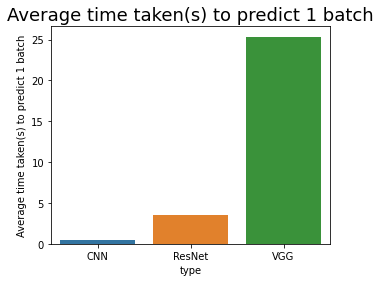

,Average time taken(s) to predict 1 batch,type,ratio
0,0.4158,CNN,1.00
1,3.5403,ResNet,8.51
2,25.3409,VGG,60.94


In [45]:
df2 = pd.DataFrame(np.array([[0.4158,3.5403,25.3409],['CNN','ResNet','VGG']]).T,
                   columns = ['Average time taken(s) to predict 1 batch', 'type'])
df2['Average time taken(s) to predict 1 batch'] = df2['Average time taken(s) to predict 1 batch'].astype('float64')
df2['ratio'] = (df2['Average time taken(s) to predict 1 batch'] / df2['Average time taken(s) to predict 1 batch'].min()).round(2)

plt.figure(figsize=(5,4))
plt.title('Average time taken(s) to predict 1 batch',fontsize=18)
sns.barplot(data=df2, x="type", y="Average time taken(s) to predict 1 batch",) 
plt.show()

df2

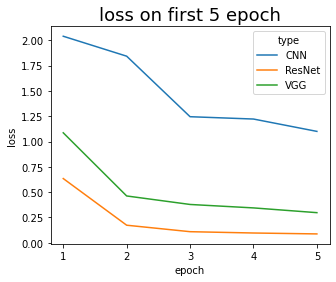

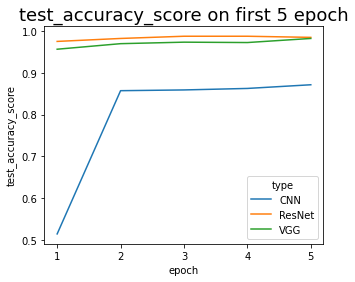

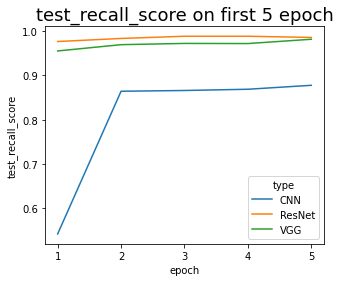

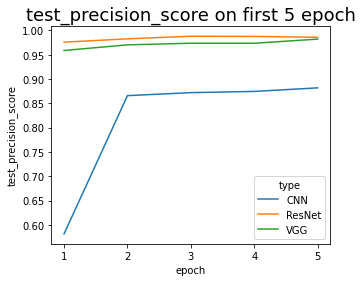

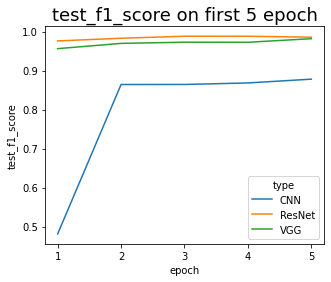

In [47]:
# Plot for first 5 epoch
plt.figure(figsize=(5,4))
plt.title('loss on first 5 epoch',fontsize=18)
sns.lineplot(data=df[df['epoch']<=5], x="epoch", y="loss", hue="type")
plt.xticks(list(range(1,5+1))) 
plt.show()

plt.figure(figsize=(5,4))
plt.title('test_accuracy_score on first 5 epoch',fontsize=18)
sns.lineplot(data=df[df['epoch']<=5], x="epoch", y="test_accuracy_score", hue="type")
plt.xticks(list(range(1,5+1))) 
plt.show()

plt.figure(figsize=(5,4))
plt.title('test_recall_score on first 5 epoch',fontsize=18)
sns.lineplot(data=df[df['epoch']<=5], x="epoch", y="test_recall_score", hue="type")
plt.xticks(list(range(1,5+1))) 
plt.show()

plt.figure(figsize=(5,4))
plt.title('test_precision_score on first 5 epoch',fontsize=18)
sns.lineplot(data=df[df['epoch']<=5], x="epoch", y="test_precision_score", hue="type")
plt.xticks(list(range(1,5+1))) 
plt.show()

plt.figure(figsize=(5,4))
plt.title('test_f1_score on first 5 epoch',fontsize=18)
sns.lineplot(data=df[df['epoch']<=5], x="epoch", y="test_f1_score", hue="type")
plt.xticks(list(range(1,5+1))) 
plt.show()


In [48]:
# Extend the line for ResNet and VGG
cur = df[(df['type'] == 'ResNet') & (df['epoch'] == 5)]
for i in range(6,50+1):
    cur['epoch'] = i
    df = df.append(cur)

cur = df[(df['type'] == 'VGG') & (df['epoch'] == 5)]
for i in range(6,50+1):
    cur['epoch'] = i
    df = df.append(cur)

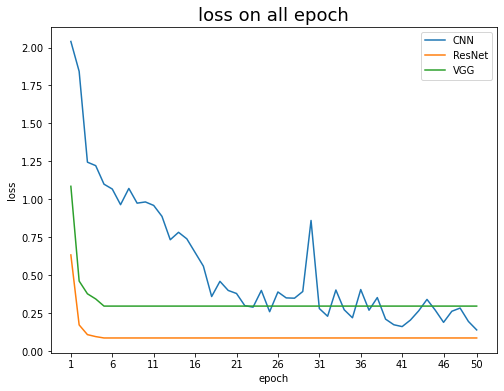

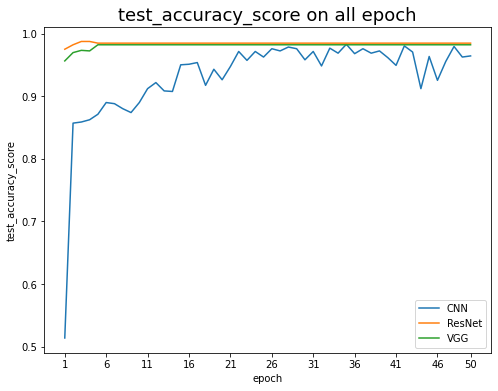

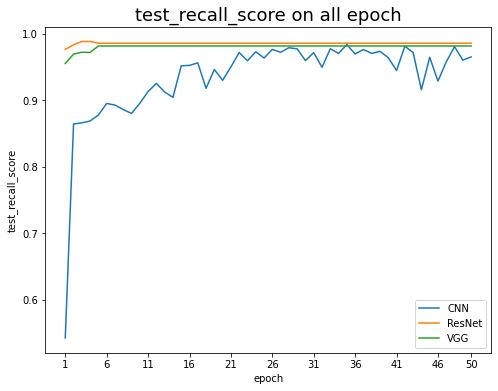

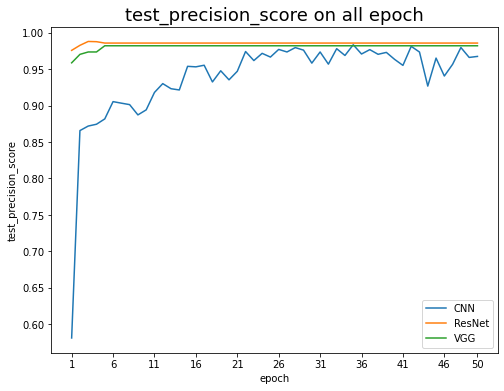

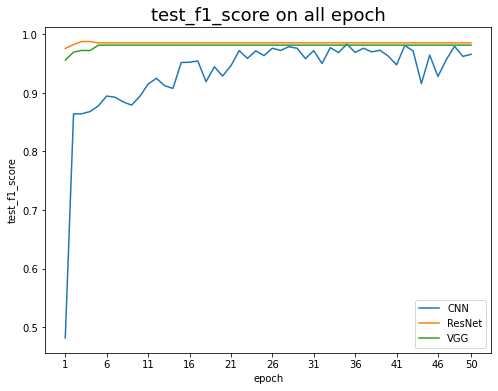

In [49]:
# On all epoch
plt.figure(figsize=(8,6))
plt.title('loss on all epoch',fontsize=18)
sns.lineplot(data=df, x="epoch", y="loss", hue="type")
plt.legend(loc='upper right')
plt.xticks(list(range(1,50+1,5))+[50])
plt.show()

plt.figure(figsize=(8,6))
plt.title('test_accuracy_score on all epoch',fontsize=18)
sns.lineplot(data=df, x="epoch", y="test_accuracy_score", hue="type")
plt.legend(loc='lower right')
plt.xticks(list(range(1,50+1,5))+[50])
plt.show()

plt.figure(figsize=(8,6))
plt.title('test_recall_score on all epoch',fontsize=18)
sns.lineplot(data=df, x="epoch", y="test_recall_score", hue="type")
plt.legend(loc='lower right')
plt.xticks(list(range(1,50+1,5))+[50])
plt.show()

plt.figure(figsize=(8,6))
plt.title('test_precision_score on all epoch',fontsize=18)
sns.lineplot(data=df, x="epoch", y="test_precision_score", hue="type")
plt.legend(loc='lower right')
plt.xticks(list(range(1,50+1,5))+[50])
plt.show()

plt.figure(figsize=(8,6))
plt.title('test_f1_score on all epoch',fontsize=18)
sns.lineplot(data=df, x="epoch", y="test_f1_score", hue="type")
plt.legend(loc='lower right')
plt.xticks(list(range(1,50+1,5))+[50])
plt.show()

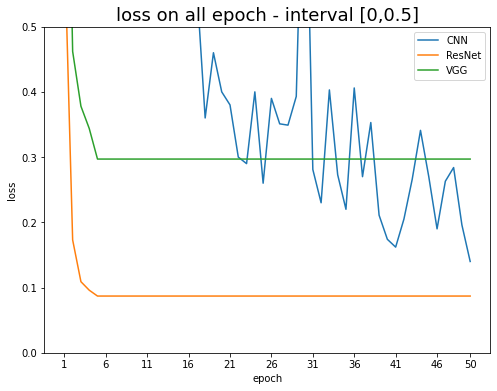

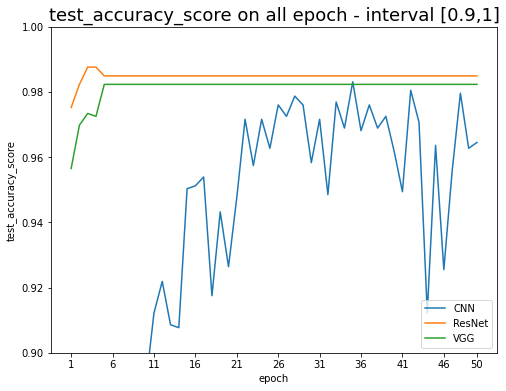

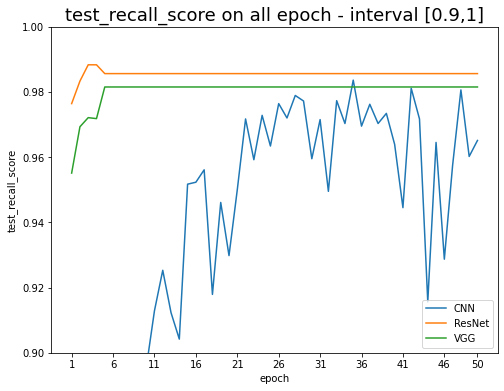

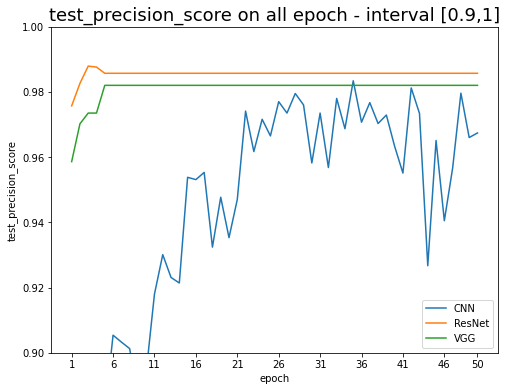

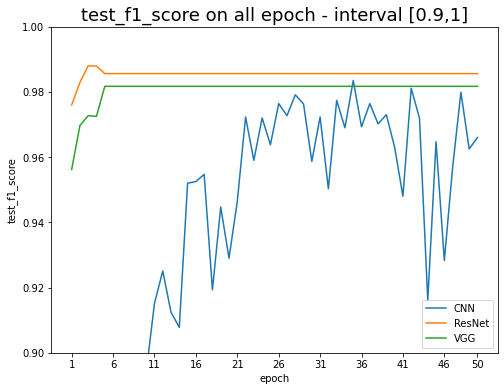

In [50]:
# Closer look
plt.figure(figsize=(8,6))
plt.title('loss on all epoch - interval [0,0.5]',fontsize=18)
sns.lineplot(data=df, x="epoch", y="loss", hue="type")
plt.ylim(0,0.5)
plt.legend(loc='upper right')
plt.xticks(list(range(1,50+1,5))+[50]) 
plt.show()

plt.figure(figsize=(8,6))
plt.title('test_accuracy_score on all epoch - interval [0.9,1]',fontsize=18)
sns.lineplot(data=df, x="epoch", y="test_accuracy_score", hue="type")
plt.ylim(0.9,1)
plt.legend(loc='lower right')
plt.xticks(list(range(1,50+1,5))+[50]) 
plt.show()

plt.figure(figsize=(8,6))
plt.title('test_recall_score on all epoch - interval [0.9,1]',fontsize=18)
sns.lineplot(data=df, x="epoch", y="test_recall_score", hue="type")
plt.ylim(0.9,1)
plt.legend(loc='lower right')
plt.xticks(list(range(1,50+1,5))+[50]) 
plt.show()

plt.figure(figsize=(8,6))
plt.title('test_precision_score on all epoch - interval [0.9,1]',fontsize=18)
sns.lineplot(data=df, x="epoch", y="test_precision_score", hue="type")
plt.ylim(0.9,1)
plt.legend(loc='lower right')
plt.xticks(list(range(1,50+1,5))+[50]) 
plt.show()

plt.figure(figsize=(8,6))
plt.title('test_f1_score on all epoch - interval [0.9,1]',fontsize=18)
sns.lineplot(data=df, x="epoch", y="test_f1_score", hue="type")
plt.ylim(0.9,1)
plt.legend(loc='lower right')
plt.xticks(list(range(1,50+1,5))+[50]) 
plt.show()

# 6. Model Selection and Demo
Select **resnet_model_00003_loss_0.109.pt** as best model

In [51]:
# Fresh model
resnet_model = models.resnet18(pretrained=False)
resnet_model = nn.Sequential(resnet_model, nn.Linear(in_features=1000, out_features=4))

# Load weights
resnet_model.load_state_dict(torch.load(r"../input/cisc3024db927491angjianhwee-trained-models/resnet_model_00003_loss_0.109.pt"))

<All keys matched successfully>

In [53]:
# Load data to be predicted
X, y_true = list(enumerate(test_dataset_loader, 0))[0][1]
y_true = y_true.tolist()


y_pred = resnet_model(X)    # Predict
y_pred = torch.argmax(y_pred,axis = 1).tolist()    # Argmax and to list

# Print first 20
print(f"y_true :{y_true[0:20]}")
print(f"y_pred :{y_pred[0:20]}")

y_true :[1, 0, 2, 2, 0, 3, 0, 3, 3, 2, 0, 0, 0, 3, 2, 3, 0, 0, 0, 1]

y_pred :[1, 0, 2, 2, 0, 3, 0, 2, 3, 2, 0, 0, 0, 3, 2, 3, 0, 0, 0, 1]
